In [1]:
%matplotlib inline

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from santander.utils import ColumnDropper
from santander.utils import ZERO_VARIANCE_COLUMNS, CORRELATED_COLUMNS

In [4]:
df_train = pd.read_csv('../data/train.csv')
df_target = df_train['TARGET']
df_train = df_train.drop(['TARGET', 'ID'], axis=1)

Best log loss train=0.127530 (round=399), test=0.136166 (round=317)
Best AUC train=0.866599 (round=399), test=0.837490 (round=398)


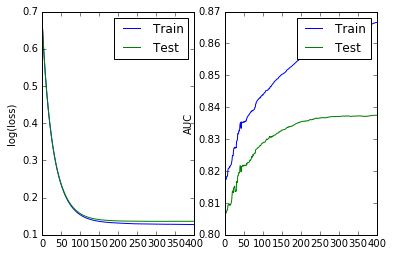

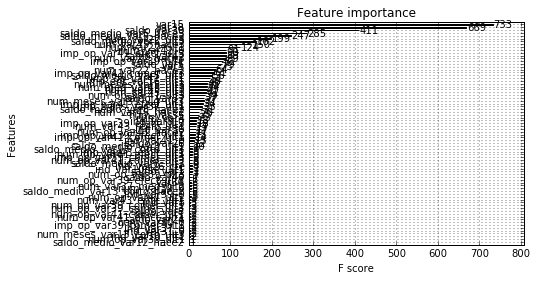

In [5]:
# xgb on raw features
X_train = df_train.copy()
y_train = df_target
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# hand-tuned params -- should grid search later
eval_metrics = ['logloss', 'auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(seed=0, learning_rate=0.025, n_estimators=400, min_child_weight=5, max_depth=4)
xgb = xgb.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets, verbose=False)

logloss = [xgb.evals_result_['validation_%d' % i]['logloss'] for i in range(len(eval_sets))]
logloss = np.array(logloss, dtype=float).T
auc = [xgb.evals_result_['validation_%d' % i]['auc'] for i in range(len(eval_sets))]
auc = np.array(auc, dtype=float).T

logloss_best_round = np.argmin(logloss, axis=0)
logloss_best = [logloss[logloss_best_round[0], 0], logloss[logloss_best_round[1], 1]]
auc_best_round = np.argmax(auc, axis=0)
auc_best = [auc[auc_best_round[0], 0], auc[auc_best_round[1], 1]]

print 'Best log loss train=%f (round=%d), test=%f (round=%d)' % (logloss_best[0], logloss_best_round[0], logloss_best[1], logloss_best_round[1])
print 'Best AUC train=%f (round=%d), test=%f (round=%d)' % (auc_best[0], auc_best_round[0], auc_best[1], auc_best_round[1])

plt.subplot(1, 2, 1)
plt.plot(logloss)
plt.legend(['Train', 'Test'])
plt.ylabel('log(loss)')
plt.subplot(1, 2, 2)
plt.plot(auc)
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

plot_importance(xgb)

Best log loss train=0.127530 (round=399), test=0.136166 (round=317)
Best AUC train=0.866599 (round=399), test=0.837490 (round=398)


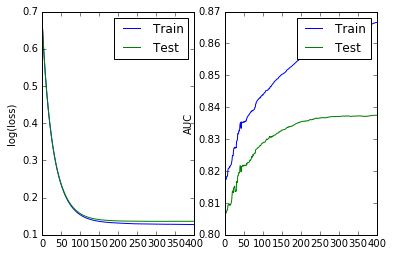

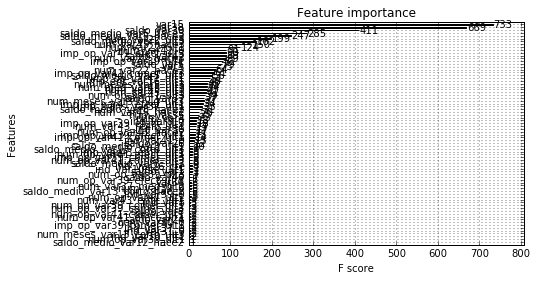

In [6]:
# xgb on dropped features

pipeline = Pipeline([
        ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS))
    ])

pipeline = pipeline.fit(df_train)
X_train = pipeline.transform(df_train)
y_train = df_target

X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# hand-tuned params -- should grid search later
eval_metrics = ['logloss', 'auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(seed=0, learning_rate=0.025, n_estimators=400, min_child_weight=5, max_depth=4)
xgb = xgb.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets, verbose=False)

logloss = [xgb.evals_result_['validation_%d' % i]['logloss'] for i in range(len(eval_sets))]
logloss = np.array(logloss, dtype=float).T
auc = [xgb.evals_result_['validation_%d' % i]['auc'] for i in range(len(eval_sets))]
auc = np.array(auc, dtype=float).T

logloss_best_round = np.argmin(logloss, axis=0)
logloss_best = [logloss[logloss_best_round[0], 0], logloss[logloss_best_round[1], 1]]
auc_best_round = np.argmax(auc, axis=0)
auc_best = [auc[auc_best_round[0], 0], auc[auc_best_round[1], 1]]

print 'Best log loss train=%f (round=%d), test=%f (round=%d)' % (logloss_best[0], logloss_best_round[0], logloss_best[1], logloss_best_round[1])
print 'Best AUC train=%f (round=%d), test=%f (round=%d)' % (auc_best[0], auc_best_round[0], auc_best[1], auc_best_round[1])

plt.subplot(1, 2, 1)
plt.plot(logloss)
plt.legend(['Train', 'Test'])
plt.ylabel('log(loss)')
plt.subplot(1, 2, 2)
plt.plot(auc)
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

plot_importance(xgb)

Best log loss train=0.124294 (round=399), test=0.139928 (round=396)
Best AUC train=0.876435 (round=399), test=0.817640 (round=396)


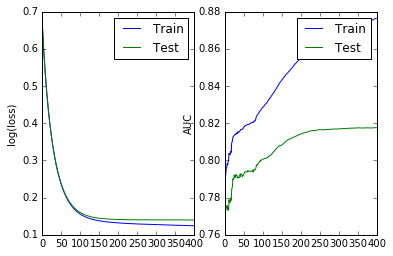

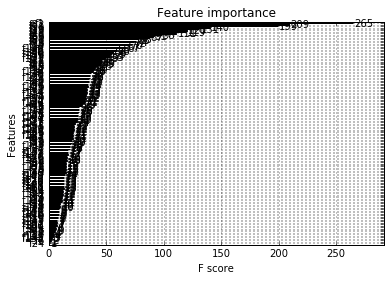

In [7]:
# experimenting with bigger pipeline
pipeline = Pipeline([
        ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS)),
        ('std', StandardScaler()),
        ('pca', PCA(n_components=150))
    ])

pipeline = pipeline.fit(df_train)
X_train = pipeline.transform(df_train)
y_train = df_target

X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# hand-tuned params -- should grid search later
eval_metrics = ['logloss', 'auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(seed=0, learning_rate=0.025, n_estimators=400, min_child_weight=5, max_depth=4)
xgb = xgb.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets, verbose=False)

logloss = [xgb.evals_result_['validation_%d' % i]['logloss'] for i in range(len(eval_sets))]
logloss = np.array(logloss, dtype=float).T
auc = [xgb.evals_result_['validation_%d' % i]['auc'] for i in range(len(eval_sets))]
auc = np.array(auc, dtype=float).T

logloss_best_round = np.argmin(logloss, axis=0)
logloss_best = [logloss[logloss_best_round[0], 0], logloss[logloss_best_round[1], 1]]
auc_best_round = np.argmax(auc, axis=0)
auc_best = [auc[auc_best_round[0], 0], auc[auc_best_round[1], 1]]

print 'Best log loss train=%f (round=%d), test=%f (round=%d)' % (logloss_best[0], logloss_best_round[0], logloss_best[1], logloss_best_round[1])
print 'Best AUC train=%f (round=%d), test=%f (round=%d)' % (auc_best[0], auc_best_round[0], auc_best[1], auc_best_round[1])

plt.subplot(1, 2, 1)
plt.plot(logloss)
plt.legend(['Train', 'Test'])
plt.ylabel('log(loss)')
plt.subplot(1, 2, 2)
plt.plot(auc)
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

plot_importance(xgb)